In [1]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from nflows import flows, transforms, distributions
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.couplings.feed_forward import FeedForwardCoupling
from src.diffeomorphisms.vector.nflow import NFlowVectorDiffeomorphism

from src.dynamics.nonlinear.hybrid_lower_triangular import HybridLowerTriangularNonlinearDynamics
from src.dynamics.nonlinear.lower_triangular.toy import ToyLowerTriangularNonlinearDynamics
from src.dynamics.linear.standard import StandardLinearDynamics

from src.nn.module.activation.polynomial import PolynomialActivation
from src.transforms.polynomial_parity import PolynomialParityTransform

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set random seed for reproducibility
torch.manual_seed(42)

# Results settings
results_folder = os.path.join("results","toy")

figsize = (8, 6)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20  # Change this value to your desired font size

### Generate data ###

In [2]:
# Construct mappings that generate the data
dynamics_model_gt = ToyLowerTriangularNonlinearDynamics()

# Construct g
W_g = -torch.tensor([1., 0.75])
b_g = torch.tensor([-1.5])

In [3]:
# Construct dataset
N = 2500
i = torch.arange(N)
S = dynamics_model_gt.forward(i)
noise_level = 0.1

x_ = S[:,0:2] 
p_ = S[:,2:]
v_ = torch.nn.functional.softplus((W_g[None] * p_).sum(1) - b_g) 

# Add noise
x = x_ + noise_level * torch.randn_like(x_)
v = v_ + noise_level * torch.randn_like(v_)

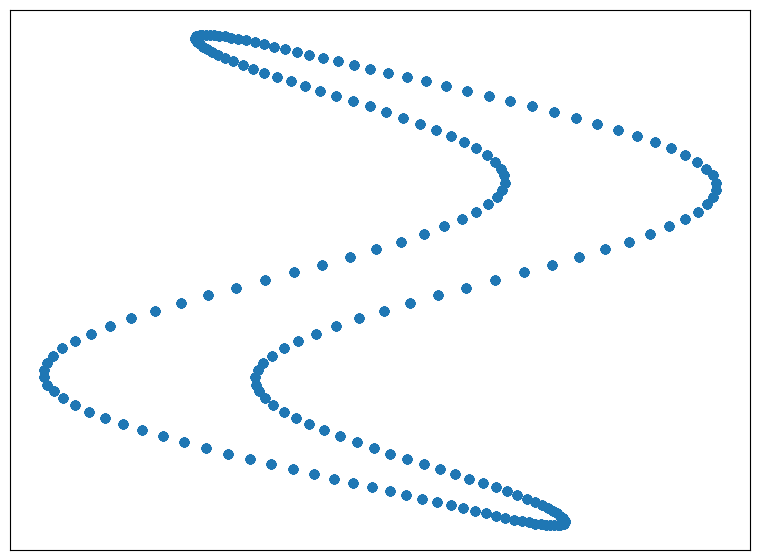

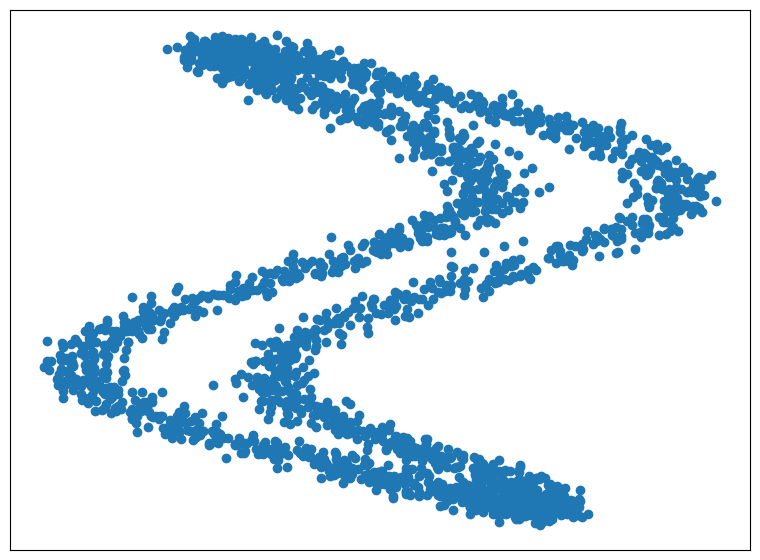

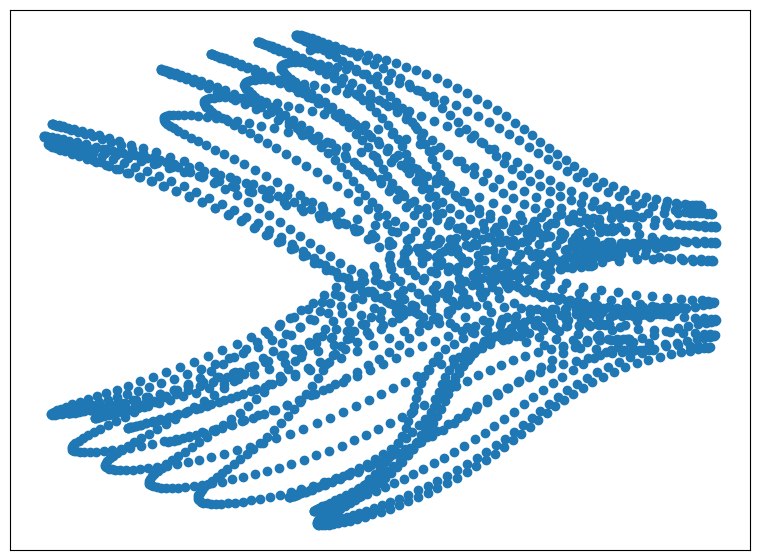

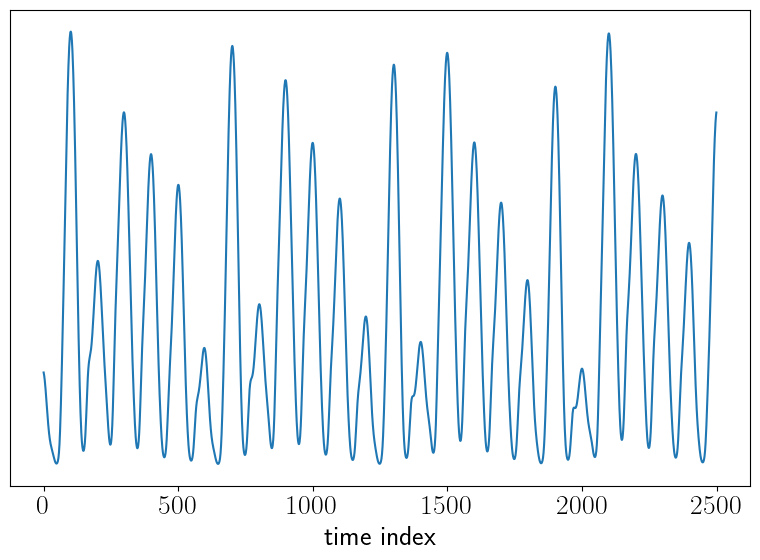

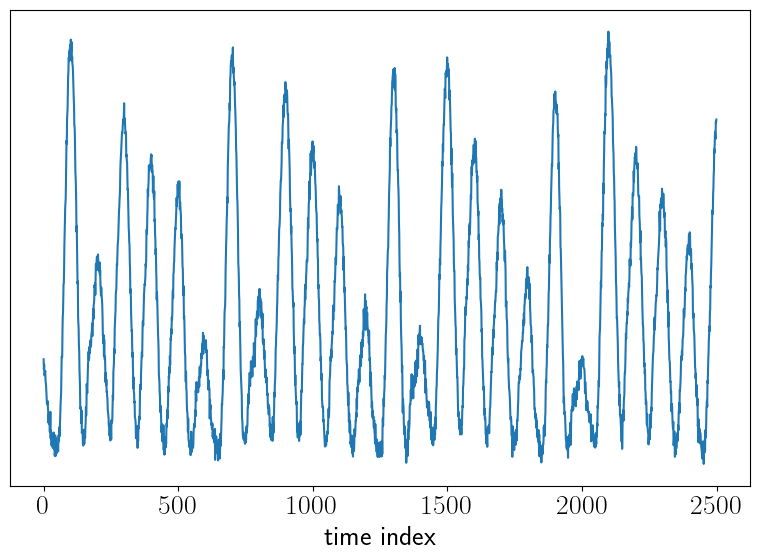

In [5]:
# Plot data dynamics
plt.figure(figsize=figsize)
plt.scatter(x_[:,0], x_[:,1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "x_data_clean.eps"))
plt.show()

# Plot data dynamics
plt.figure(figsize=figsize)
plt.scatter(x[:,0], x[:,1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "x_data.eps"))
plt.show()

# Plot latent dynamics
plt.figure(figsize=figsize)
plt.scatter(p_[:,0], p_[:,1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "p_data_clean.eps"))
plt.show()

# Plot signal
plt.figure(figsize=figsize)
plt.plot(i, v_)
plt.yticks([])  # Remove y-axis ticks
plt.xlabel("time index")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "v_data_clean.eps"))
plt.show()

# Plot signal
plt.figure(figsize=figsize)
plt.plot(i, v)
plt.yticks([])  # Remove y-axis ticks
plt.xlabel("time index")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "v_data.eps"))
plt.show()

In [4]:
# Split data into train and validation
split = 0.8
n_ = int(split * len(i))
i_train = i[:n_].float()
x_train = x[:n_].float()
v_train = v[:n_].float()
i_val = i[n_:].float()
x_val = x[n_:].float()
v_val = v[n_:].float()

### Reconstruct using LDDMD ###

In [6]:
# Construct data loader
class TimeSeriesDataset(Dataset):
    def __init__(self, i, x, v):
        self.i = i
        self.x = x
        self.v = v

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (
            self.i[idx,None],
            self.x[idx],
            self.v[idx,None]
        )

# Create the dataset
dataset = TimeSeriesDataset(i_train, x_train, v_train) 

# Create the DataLoader
batch_size = 256  # Adjust as needed
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
# Define additional neural network helpers
def create_flow_model(dim, n_flows, order):
    base_dist = distributions.StandardNormal(shape=[dim])
    transforms_list = []
    for _ in range(n_flows):
        transforms_list.append(PolynomialParityTransform(dim, order, parity=1))
    flow_transforms = transforms.CompositeTransform(transforms_list)
    return NFlowVectorDiffeomorphism(dim, flows.Flow(transform=flow_transforms, distribution=base_dist))

def create_feed_forward_model(dim_in, dim_out, n_layers, hidden_dim, order):
    if hidden_dim is None:
        hidden_dim = dim_in
    layers = []
    layers.append(nn.Linear(dim_in, hidden_dim))
    for _ in range(n_layers-1):
        layers.append(PolynomialActivation(hidden_dim, order))
        layers.append(nn.Linear(hidden_dim, hidden_dim))
    layers.append(PolynomialActivation(hidden_dim, order))
    layers.append(nn.Linear(hidden_dim, dim_out))
    return FeedForwardCoupling(dim_in, dim_out, nn.Sequential(*layers))

def create_dynamics_model(dim, dt, freqs, decays=None, init=None):
    assert dim % 2 == 0
    omegas = nn.Parameter(freqs)
    if decays is None:
        mus = torch.zeros(dim//2)
    else:
        mus = nn.Parameter(decays)
    if init is None:
        x0 = nn.Parameter(torch.zeros(dim))
    else:
        x0 = nn.Parameter(init)
    return StandardLinearDynamics(dim, dt, mus, omegas, x0)

def create_regression_model(dim_in, hidden_dim):
    layers = []
    layers.append(nn.Linear(dim_in, hidden_dim))
    layers.append(nn.Softplus()) 
    layers.append(nn.Linear(hidden_dim, 1))
    
    return nn.Sequential(*layers)

Top dominant frequencies:
0.009999999776482582
Ground truth frequencies:
0.009934588335454464


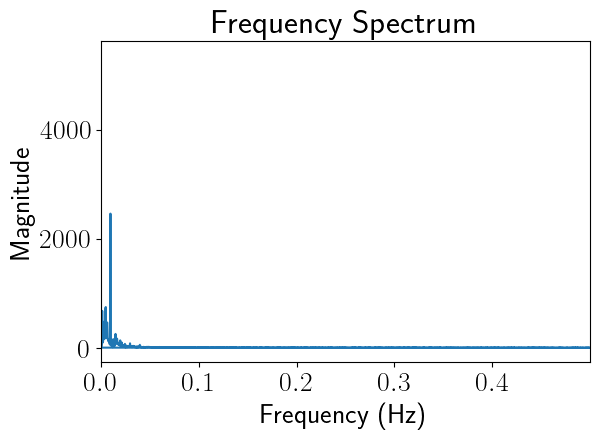

In [8]:
# Compute the FFT
fft_result = torch.fft.fft(v)

# Compute the frequency bins
n = len(i)
sample_rate = 1 / (dynamics_model_gt.dt.item() * (i[1] - i[0]))  # Assuming uniform sampling
freqs = torch.fft.fftfreq(n, d=1/sample_rate)

# Compute the magnitude spectrum
magnitude_spectrum = torch.abs(fft_result)

# Find the dominant frequencies
dominant_freqs = freqs[torch.argsort(magnitude_spectrum, descending=True)]

# Print the top dominant frequencies
print("Top dominant frequencies:")
print(dominant_freqs[1].abs().item())
print("Ground truth frequencies:")
print(dynamics_model_gt.K_2.omegas.item())

plt.plot(freqs, magnitude_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum')
plt.xlim(0, freqs.max())  # Display only positive frequencies
plt.tight_layout()
plt.show()

In [9]:
# Initialize the models
data_dim = 2
latent_dim = 2

n_latent_flows = 1
phi_p = create_flow_model(latent_dim, n_latent_flows, 2)

n_coupling_layers = 2
hidden_dim_f = 2
f = create_feed_forward_model(data_dim, latent_dim, n_coupling_layers, hidden_dim_f, 2)

dt = dynamics_model_gt.dt
freqs = torch.tensor([dominant_freqs[1]]).abs()
K_p = create_dynamics_model(latent_dim, dt, freqs)

dynamics_model = HybridLowerTriangularNonlinearDynamics(K_p, phi_p, f).to(device)

hidden_dim_g = 4
regression_model = create_regression_model(latent_dim, hidden_dim_g).to(device)

# Combine all parameters from different components
all_params = list(dynamics_model.parameters()) + list(regression_model.parameters())

# Create the optimizer
optimizer = optim.Adam(all_params, lr=1e-3)

In [10]:
# Training loop
def train(dynamics_model, regression_model, train_loader, optimizer, n_epochs):
    loss_progression = []
    for epoch in range(n_epochs):
        for i_batch, x_batch, v_batch in tqdm(train_loader):
            optimizer.zero_grad()
            
            # Compute predictions
            p_batch_net = dynamics_model.forward(i_batch, x_batch)
            v_batch_net = regression_model(p_batch_net)

            # Compute data fidelity loss
            loss = ((v_batch - v_batch_net).abs()).mean() # l1 loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")
        # Save last loss of the epoch
        loss_progression.append(loss.item())
    return loss_progression

In [ ]:
# Train the model
n_epochs = 1000
losses = train(dynamics_model, regression_model, train_loader, optimizer, n_epochs)

100%|██████████| 8/8 [00:00<00:00, 36.34it/s]


Epoch 1/1000, Loss: 2.3349


100%|██████████| 8/8 [00:00<00:00, 85.56it/s]


Epoch 2/1000, Loss: 2.4066


100%|██████████| 8/8 [00:00<00:00, 115.30it/s]


Epoch 3/1000, Loss: 2.7383


100%|██████████| 8/8 [00:00<00:00, 137.99it/s]


Epoch 4/1000, Loss: 2.5673


100%|██████████| 8/8 [00:00<00:00, 142.99it/s]


Epoch 5/1000, Loss: 2.5118


100%|██████████| 8/8 [00:00<00:00, 133.60it/s]


Epoch 6/1000, Loss: 2.3903


100%|██████████| 8/8 [00:00<00:00, 130.51it/s]


Epoch 7/1000, Loss: 2.2326


100%|██████████| 8/8 [00:00<00:00, 116.85it/s]


Epoch 8/1000, Loss: 2.1777


100%|██████████| 8/8 [00:00<00:00, 102.49it/s]


Epoch 9/1000, Loss: 1.9921


100%|██████████| 8/8 [00:00<00:00, 105.91it/s]


Epoch 10/1000, Loss: 2.2602


100%|██████████| 8/8 [00:00<00:00, 81.12it/s]


Epoch 11/1000, Loss: 2.0603


100%|██████████| 8/8 [00:00<00:00, 96.20it/s]


Epoch 12/1000, Loss: 1.9873


100%|██████████| 8/8 [00:00<00:00, 105.66it/s]


Epoch 13/1000, Loss: 1.7710


100%|██████████| 8/8 [00:00<00:00, 101.10it/s]


Epoch 14/1000, Loss: 1.7850


100%|██████████| 8/8 [00:00<00:00, 106.38it/s]


Epoch 15/1000, Loss: 1.3834


100%|██████████| 8/8 [00:00<00:00, 107.13it/s]


Epoch 16/1000, Loss: 1.3494


100%|██████████| 8/8 [00:00<00:00, 33.91it/s]


Epoch 17/1000, Loss: 1.1986


100%|██████████| 8/8 [00:00<00:00, 118.65it/s]


Epoch 18/1000, Loss: 1.0016


100%|██████████| 8/8 [00:00<00:00, 119.55it/s]


Epoch 19/1000, Loss: 0.8926


100%|██████████| 8/8 [00:00<00:00, 130.63it/s]


Epoch 20/1000, Loss: 0.8056


100%|██████████| 8/8 [00:00<00:00, 87.77it/s]


Epoch 21/1000, Loss: 0.7229


100%|██████████| 8/8 [00:00<00:00, 58.57it/s]


Epoch 22/1000, Loss: 0.6950


100%|██████████| 8/8 [00:00<00:00, 61.44it/s]


Epoch 23/1000, Loss: 0.6383


100%|██████████| 8/8 [00:00<00:00, 128.71it/s]


Epoch 24/1000, Loss: 0.6369


100%|██████████| 8/8 [00:00<00:00, 130.40it/s]


Epoch 25/1000, Loss: 0.6480


100%|██████████| 8/8 [00:00<00:00, 86.48it/s]


Epoch 26/1000, Loss: 0.6496


100%|██████████| 8/8 [00:00<00:00, 82.15it/s]


Epoch 27/1000, Loss: 0.6565


100%|██████████| 8/8 [00:00<00:00, 76.92it/s]


Epoch 28/1000, Loss: 0.5705


100%|██████████| 8/8 [00:00<00:00, 101.46it/s]


Epoch 29/1000, Loss: 0.6416


100%|██████████| 8/8 [00:00<00:00, 68.31it/s]


Epoch 30/1000, Loss: 0.6538


100%|██████████| 8/8 [00:00<00:00, 73.23it/s]


Epoch 31/1000, Loss: 0.6400


100%|██████████| 8/8 [00:00<00:00, 119.01it/s]


Epoch 32/1000, Loss: 0.6314


100%|██████████| 8/8 [00:00<00:00, 125.36it/s]


Epoch 33/1000, Loss: 0.6610


100%|██████████| 8/8 [00:00<00:00, 131.55it/s]


Epoch 34/1000, Loss: 0.6721


100%|██████████| 8/8 [00:00<00:00, 123.81it/s]


Epoch 35/1000, Loss: 0.6929


100%|██████████| 8/8 [00:00<00:00, 109.57it/s]


Epoch 36/1000, Loss: 0.5664


100%|██████████| 8/8 [00:00<00:00, 108.70it/s]


Epoch 37/1000, Loss: 0.6500


100%|██████████| 8/8 [00:00<00:00, 125.72it/s]


Epoch 38/1000, Loss: 0.6238


100%|██████████| 8/8 [00:00<00:00, 139.97it/s]


Epoch 39/1000, Loss: 0.5752


100%|██████████| 8/8 [00:00<00:00, 147.21it/s]


Epoch 40/1000, Loss: 0.6462


100%|██████████| 8/8 [00:00<00:00, 133.36it/s]


Epoch 41/1000, Loss: 0.6181


100%|██████████| 8/8 [00:00<00:00, 137.77it/s]


Epoch 42/1000, Loss: 0.6198


100%|██████████| 8/8 [00:00<00:00, 138.43it/s]


Epoch 43/1000, Loss: 0.6336


100%|██████████| 8/8 [00:00<00:00, 53.12it/s]


Epoch 44/1000, Loss: 0.7033


100%|██████████| 8/8 [00:00<00:00, 146.06it/s]


Epoch 45/1000, Loss: 0.5903


100%|██████████| 8/8 [00:00<00:00, 138.29it/s]


Epoch 46/1000, Loss: 0.6153


100%|██████████| 8/8 [00:00<00:00, 138.66it/s]


Epoch 47/1000, Loss: 0.6508


100%|██████████| 8/8 [00:00<00:00, 151.53it/s]


Epoch 48/1000, Loss: 0.5845


100%|██████████| 8/8 [00:00<00:00, 151.82it/s]


Epoch 49/1000, Loss: 0.5653


100%|██████████| 8/8 [00:00<00:00, 156.52it/s]


Epoch 50/1000, Loss: 0.6242


100%|██████████| 8/8 [00:00<00:00, 151.54it/s]


Epoch 51/1000, Loss: 0.5772


100%|██████████| 8/8 [00:00<00:00, 153.21it/s]


Epoch 52/1000, Loss: 0.5741


100%|██████████| 8/8 [00:00<00:00, 150.82it/s]


Epoch 53/1000, Loss: 0.5868


100%|██████████| 8/8 [00:00<00:00, 150.56it/s]


Epoch 54/1000, Loss: 0.4884


100%|██████████| 8/8 [00:00<00:00, 153.64it/s]


Epoch 55/1000, Loss: 0.5750


100%|██████████| 8/8 [00:00<00:00, 147.13it/s]


Epoch 56/1000, Loss: 0.6412


100%|██████████| 8/8 [00:00<00:00, 78.85it/s]


Epoch 57/1000, Loss: 0.5146


100%|██████████| 8/8 [00:00<00:00, 147.13it/s]


Epoch 58/1000, Loss: 0.6215


100%|██████████| 8/8 [00:00<00:00, 137.18it/s]


Epoch 59/1000, Loss: 0.5922


100%|██████████| 8/8 [00:00<00:00, 126.36it/s]


Epoch 60/1000, Loss: 0.5730


100%|██████████| 8/8 [00:00<00:00, 121.67it/s]


Epoch 61/1000, Loss: 0.5678


100%|██████████| 8/8 [00:00<00:00, 129.70it/s]


Epoch 62/1000, Loss: 0.5370


100%|██████████| 8/8 [00:00<00:00, 154.38it/s]


Epoch 63/1000, Loss: 0.5526


100%|██████████| 8/8 [00:00<00:00, 151.42it/s]


Epoch 64/1000, Loss: 0.5926


100%|██████████| 8/8 [00:00<00:00, 153.20it/s]


Epoch 65/1000, Loss: 0.5193


100%|██████████| 8/8 [00:00<00:00, 150.88it/s]


Epoch 66/1000, Loss: 0.5956


100%|██████████| 8/8 [00:00<00:00, 129.00it/s]


Epoch 67/1000, Loss: 0.5871


100%|██████████| 8/8 [00:00<00:00, 155.95it/s]


Epoch 68/1000, Loss: 0.6125


100%|██████████| 8/8 [00:00<00:00, 133.63it/s]


Epoch 69/1000, Loss: 0.5677


100%|██████████| 8/8 [00:00<00:00, 131.93it/s]


Epoch 70/1000, Loss: 0.6224


100%|██████████| 8/8 [00:00<00:00, 131.14it/s]


Epoch 71/1000, Loss: 0.5181


100%|██████████| 8/8 [00:00<00:00, 129.46it/s]


Epoch 72/1000, Loss: 0.5272


100%|██████████| 8/8 [00:00<00:00, 120.03it/s]


Epoch 73/1000, Loss: 0.5257


100%|██████████| 8/8 [00:00<00:00, 133.22it/s]


Epoch 74/1000, Loss: 0.5139


100%|██████████| 8/8 [00:00<00:00, 153.73it/s]


Epoch 75/1000, Loss: 0.5470


100%|██████████| 8/8 [00:00<00:00, 139.57it/s]


Epoch 76/1000, Loss: 0.6012


100%|██████████| 8/8 [00:00<00:00, 131.68it/s]


Epoch 77/1000, Loss: 0.5170


100%|██████████| 8/8 [00:00<00:00, 124.90it/s]


Epoch 78/1000, Loss: 0.5340


100%|██████████| 8/8 [00:00<00:00, 117.18it/s]


Epoch 79/1000, Loss: 0.5005


100%|██████████| 8/8 [00:00<00:00, 113.58it/s]


Epoch 80/1000, Loss: 0.5439


100%|██████████| 8/8 [00:00<00:00, 111.15it/s]


Epoch 81/1000, Loss: 0.4944


100%|██████████| 8/8 [00:00<00:00, 120.24it/s]


Epoch 82/1000, Loss: 0.5437


100%|██████████| 8/8 [00:00<00:00, 108.64it/s]


Epoch 83/1000, Loss: 0.5333


100%|██████████| 8/8 [00:00<00:00, 114.79it/s]


Epoch 84/1000, Loss: 0.4868


100%|██████████| 8/8 [00:00<00:00, 133.54it/s]


Epoch 85/1000, Loss: 0.4812


100%|██████████| 8/8 [00:00<00:00, 128.71it/s]


Epoch 86/1000, Loss: 0.5061


100%|██████████| 8/8 [00:00<00:00, 129.03it/s]


Epoch 87/1000, Loss: 0.5369


100%|██████████| 8/8 [00:00<00:00, 133.69it/s]


Epoch 88/1000, Loss: 0.4979


100%|██████████| 8/8 [00:00<00:00, 130.86it/s]


Epoch 89/1000, Loss: 0.4815


100%|██████████| 8/8 [00:00<00:00, 95.12it/s]


Epoch 90/1000, Loss: 0.5004


100%|██████████| 8/8 [00:00<00:00, 114.46it/s]


Epoch 91/1000, Loss: 0.5250


100%|██████████| 8/8 [00:00<00:00, 118.39it/s]


Epoch 92/1000, Loss: 0.5101


100%|██████████| 8/8 [00:00<00:00, 117.14it/s]


Epoch 93/1000, Loss: 0.5183


100%|██████████| 8/8 [00:00<00:00, 117.48it/s]


Epoch 94/1000, Loss: 0.4912


100%|██████████| 8/8 [00:00<00:00, 117.19it/s]


Epoch 95/1000, Loss: 0.4995


100%|██████████| 8/8 [00:00<00:00, 119.08it/s]


Epoch 96/1000, Loss: 0.4690


100%|██████████| 8/8 [00:00<00:00, 130.08it/s]


Epoch 97/1000, Loss: 0.4880


100%|██████████| 8/8 [00:00<00:00, 126.60it/s]


Epoch 98/1000, Loss: 0.4974


100%|██████████| 8/8 [00:00<00:00, 101.20it/s]


Epoch 99/1000, Loss: 0.5142


100%|██████████| 8/8 [00:00<00:00, 106.87it/s]


Epoch 100/1000, Loss: 0.5053


100%|██████████| 8/8 [00:00<00:00, 120.96it/s]


Epoch 101/1000, Loss: 0.5263


100%|██████████| 8/8 [00:00<00:00, 127.37it/s]


Epoch 102/1000, Loss: 0.5305


100%|██████████| 8/8 [00:00<00:00, 101.71it/s]


Epoch 103/1000, Loss: 0.5356


100%|██████████| 8/8 [00:00<00:00, 114.07it/s]


Epoch 104/1000, Loss: 0.4832


100%|██████████| 8/8 [00:00<00:00, 118.95it/s]


Epoch 105/1000, Loss: 0.5367


100%|██████████| 8/8 [00:00<00:00, 122.89it/s]


Epoch 106/1000, Loss: 0.4871


100%|██████████| 8/8 [00:00<00:00, 129.91it/s]


Epoch 107/1000, Loss: 0.4704


100%|██████████| 8/8 [00:00<00:00, 156.58it/s]


Epoch 108/1000, Loss: 0.5115


100%|██████████| 8/8 [00:00<00:00, 156.87it/s]


Epoch 109/1000, Loss: 0.5011


100%|██████████| 8/8 [00:00<00:00, 141.36it/s]


Epoch 110/1000, Loss: 0.4915


100%|██████████| 8/8 [00:00<00:00, 119.01it/s]


Epoch 111/1000, Loss: 0.4996


100%|██████████| 8/8 [00:00<00:00, 113.81it/s]


Epoch 112/1000, Loss: 0.5544


100%|██████████| 8/8 [00:00<00:00, 109.57it/s]


Epoch 113/1000, Loss: 0.4221


  0%|          | 0/8 [00:00<?, ?it/s]

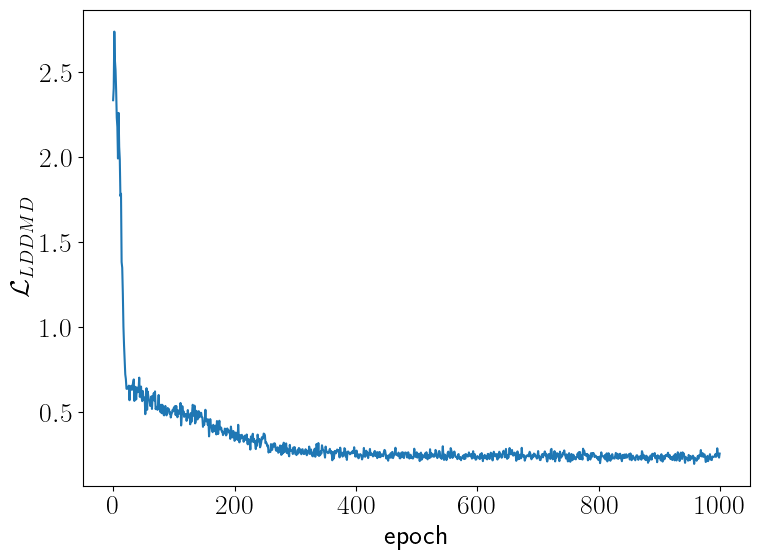

In [ ]:
# Plot loss progression
plt.figure(figsize=figsize)
plt.plot(losses)
plt.ylabel(r"$\mathcal{L}_{LDDMD}$")
plt.xlabel("epoch")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "loss.eps"))
plt.show()

In [ ]:
# Validate the model
S_net = dynamics_model.forward(i, x)

p_net = S_net.detach().cpu()
v_net = regression_model(p_net).detach().cpu().squeeze()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


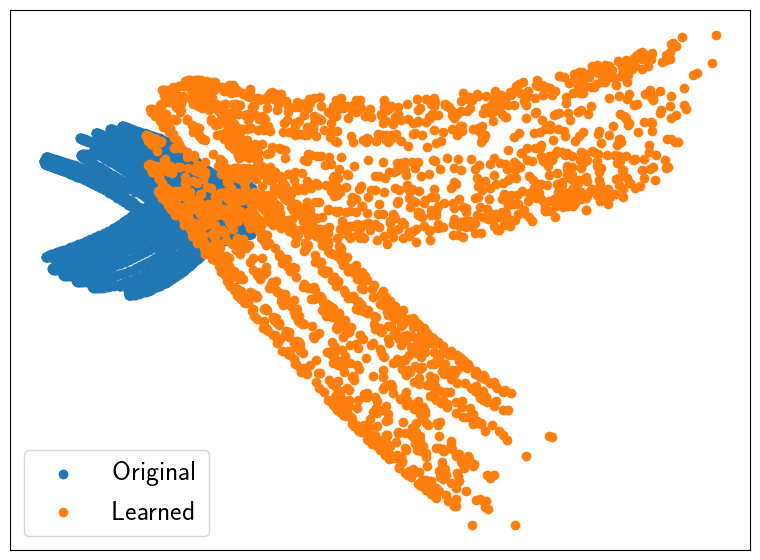

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


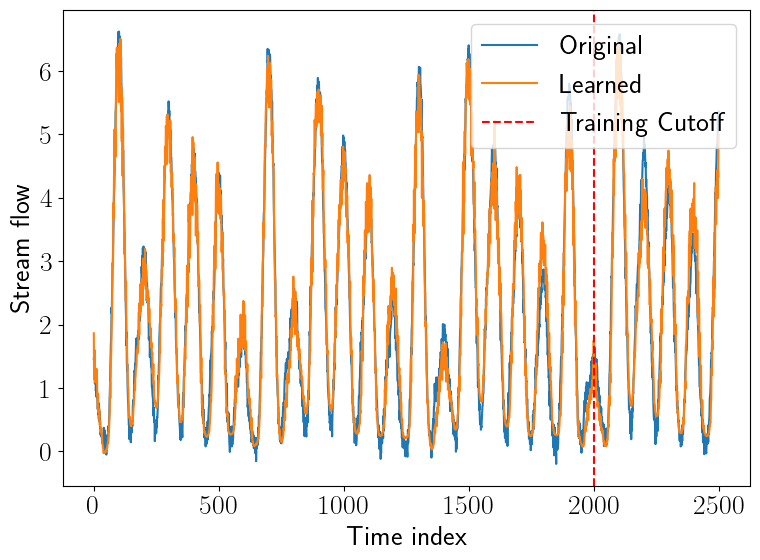

In [ ]:
# Plot learned latent dynamics
plt.figure(figsize=figsize)
plt.scatter(p_[:,0], p_[:,1], label='Original')
plt.scatter(p_net[:,0], p_net[:,1], label='Learned')
plt.legend()
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "p_reconstruction.eps"))
plt.show()

# Plot learned signal
plt.figure(figsize=figsize)
plt.plot(i, v, label='Original')
plt.plot(i, v_net, label='Learned')
plt.axvline(x=i_train[-1], color='r', linestyle='--', label='Training Cutoff')
plt.legend(loc='upper right')
plt.xlabel("Time index")
plt.ylabel("Stream flow")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "v_reconstruction.eps"))
plt.show()


In [ ]:
# define NSE metric
def nse(original, predicted):
    
    if original.shape != predicted.shape:
        raise ValueError("Input tensors must have the same shape")
    
    mean_observed = torch.mean(original)
    numerator = torch.sum((original - predicted) ** 2)
    denominator = torch.sum((original - mean_observed) ** 2)

    return 1 - (numerator / denominator)

In [ ]:
# Compute NSE metrics
total_nse = nse(v, v_net)

# Training NSE
train_nse = nse(v[:int(i_train[-1].item())+1], v_net[:int(i_train[-1].item())+1])

# Validation NSE
val_nse = nse(v[int(i_train[-1].item())+1:], v_net[int(i_train[-1].item())+1:])

print(f"Total NSE = {total_nse} | NSE on training data = {train_nse} | NSE on validation data = {val_nse}")

Total NSE = 0.9582781195640564 | NSE on training data = 0.9632235169410706 | NSE on validation data = 0.9382321238517761


In [ ]:
for name, param in dynamics_model.K.named_parameters():
    if name == "omegas":
        print(f"Parameter values:\n{param.data}\n")

print(freqs)

Parameter values:
tensor([0.0097])

tensor([0.0097])


### Reconstruct using LSTM ###

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, v, window_size):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.v = torch.tensor(v, dtype=torch.float32)
        self.window_size = window_size

    def __len__(self):
        return len(self.x) - self.window_size + 1

    def __getitem__(self, idx):
        return (
            self.x[idx:idx+self.window_size],
            self.v[idx+self.window_size-1]
        )

# Create the dataset
window_size = 365
dataset = TimeSeriesDataset(x_train, v_train, window_size)

# Create the DataLoader
batch_size = 256  # Adjust as needed
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

/var/folders/ly/f4m8s6ks3w5cc8_y1dv124bc0000gn/T/ipykernel_6440/116271639.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)
/var/folders/ly/f4m8s6ks3w5cc8_y1dv124bc0000gn/T/ipykernel_6440/116271639.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.v = torch.tensor(v, dtype=torch.float32)


In [6]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_dim, embedding_hidden_dim, embedding_output_dim, lstm_hidden_dim):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Linear(input_dim, embedding_hidden_dim),
            nn.ReLU(),
            nn.Linear(embedding_hidden_dim, embedding_hidden_dim),
            nn.ReLU(),
            nn.Linear(embedding_hidden_dim, embedding_output_dim))
        self.lstm = torch.nn.LSTM(input_size=embedding_output_dim, 
                                  hidden_size=lstm_hidden_dim, batch_first=True)
        self.lstm.bias_ih_l0.data[lstm_hidden_dim:2*lstm_hidden_dim] = 3
        self.lstm.bias_hh_l0.data[lstm_hidden_dim:2*lstm_hidden_dim] = 3
        self.output_dropout = nn.Dropout(0.4) 
        self.linear = torch.nn.Linear(lstm_hidden_dim, 1)

    def forward(self, x):
        N, L, d = x.shape
        embedding_out = self.embed(x.reshape(-1, d)).reshape(N,L,-1)
        lstm_out, _ = self.lstm(embedding_out) 
        lstm_dropout = self.output_dropout(lstm_out) 
        last_time_step = lstm_dropout[:, -1, :]
        return self.linear(last_time_step)

In [7]:
# Initialize the models
data_dim = 2
embedding_hidden_dim = 64
embedding_output_dim = 8
lstm_hidden_dim = 20

lstm_model = LSTMModel(input_dim=data_dim, 
                       embedding_hidden_dim=embedding_hidden_dim, 
                       embedding_output_dim=embedding_output_dim, 
                       lstm_hidden_dim=lstm_hidden_dim).to(device)

# Create the optimizer
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)

In [8]:
def train(lstm_model, train_loader, optimizer, n_epochs):
    device = next(lstm_model.parameters()).device
    criterion = torch.nn.MSELoss()
    
    for epoch in range(n_epochs):
        lstm_model.train()
        total_loss = 0
        
        for batch_x, batch_v in tqdm(train_loader):
            batch_x = batch_x.to(device)
            batch_v = batch_v.to(device)
            
            # Forward pass
            predictions = lstm_model(batch_x)
            
            # Optimization step
            optimizer.zero_grad()
            loss = criterion(predictions, batch_v)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(
                lstm_model.parameters(), 
                max_norm=1.0,        
                norm_type=2,         
                error_if_nonfinite=True
            )
            
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{n_epochs}] | Loss: {total_loss/len(train_loader):.4f}")


In [9]:
# Train the model
n_epochs = 100
losses = train(lstm_model, train_loader, optimizer, n_epochs)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/wdiepeveen/Documents/Postdoc/projects/3 - Riemannian geometry for data reduction for science/src/Latent-Diffeomorphic-Dynamic-Mode-Decomposition/.venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 86%|████████▌ | 6/7 [00:01<00:00,  3.88it/s]/Users/wdiepeveen/Documents/Postdoc/projects/3 - Riemannian geometry for data reduction for science/src/Latent-Diffeomorphic-Dynamic-Mode-Decomposition/.venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same

Epoch [1/100] | Loss: 7.0851


100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


Epoch [2/100] | Loss: 6.3953


100%|██████████| 7/7 [00:01<00:00,  4.59it/s]


Epoch [3/100] | Loss: 5.8622


100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


Epoch [4/100] | Loss: 5.6550


100%|██████████| 7/7 [00:01<00:00,  4.96it/s]


Epoch [5/100] | Loss: 5.3799


100%|██████████| 7/7 [00:01<00:00,  5.01it/s]


Epoch [6/100] | Loss: 4.8189


100%|██████████| 7/7 [00:01<00:00,  5.04it/s]


Epoch [7/100] | Loss: 4.3877


100%|██████████| 7/7 [00:01<00:00,  5.08it/s]


Epoch [8/100] | Loss: 3.9806


100%|██████████| 7/7 [00:01<00:00,  5.00it/s]


Epoch [9/100] | Loss: 3.5541


100%|██████████| 7/7 [00:01<00:00,  4.63it/s]


Epoch [10/100] | Loss: 3.3433


100%|██████████| 7/7 [00:01<00:00,  5.06it/s]


Epoch [11/100] | Loss: 3.1575


100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


Epoch [12/100] | Loss: 3.0620


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


Epoch [13/100] | Loss: 3.1080


100%|██████████| 7/7 [00:01<00:00,  4.08it/s]


Epoch [14/100] | Loss: 3.0942


100%|██████████| 7/7 [00:01<00:00,  3.73it/s]


Epoch [15/100] | Loss: 3.1060


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch [16/100] | Loss: 3.0379


100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


Epoch [17/100] | Loss: 3.0819


100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


Epoch [18/100] | Loss: 3.1043


100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


Epoch [19/100] | Loss: 3.0303


100%|██████████| 7/7 [00:01<00:00,  4.88it/s]


Epoch [20/100] | Loss: 3.1127


100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


Epoch [21/100] | Loss: 3.0809


100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


Epoch [22/100] | Loss: 3.0205


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


Epoch [23/100] | Loss: 2.9978


100%|██████████| 7/7 [00:01<00:00,  3.99it/s]


Epoch [24/100] | Loss: 3.0514


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Epoch [25/100] | Loss: 3.1108


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch [26/100] | Loss: 3.0070


100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


Epoch [27/100] | Loss: 3.0208


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch [28/100] | Loss: 3.0560


100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


Epoch [29/100] | Loss: 2.9795


100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


Epoch [30/100] | Loss: 3.0274


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [31/100] | Loss: 2.9813


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [32/100] | Loss: 3.0022


100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


Epoch [33/100] | Loss: 3.0304


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch [34/100] | Loss: 3.0120


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch [35/100] | Loss: 3.0416


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch [36/100] | Loss: 2.9260


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch [37/100] | Loss: 2.9367


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch [38/100] | Loss: 2.9375


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch [39/100] | Loss: 3.0401


100%|██████████| 7/7 [00:01<00:00,  4.74it/s]


Epoch [40/100] | Loss: 2.9841


100%|██████████| 7/7 [00:01<00:00,  5.24it/s]


Epoch [41/100] | Loss: 2.9921


100%|██████████| 7/7 [00:01<00:00,  4.99it/s]


Epoch [42/100] | Loss: 2.9316


100%|██████████| 7/7 [00:01<00:00,  5.18it/s]


Epoch [43/100] | Loss: 2.9981


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch [44/100] | Loss: 3.0315


100%|██████████| 7/7 [00:01<00:00,  5.23it/s]


Epoch [45/100] | Loss: 2.9979


100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Epoch [46/100] | Loss: 2.9509


100%|██████████| 7/7 [00:01<00:00,  5.21it/s]


Epoch [47/100] | Loss: 2.9525


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch [48/100] | Loss: 2.9437


100%|██████████| 7/7 [00:01<00:00,  5.14it/s]


Epoch [49/100] | Loss: 3.0321


100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


Epoch [50/100] | Loss: 2.9626


100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Epoch [51/100] | Loss: 3.0288


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch [52/100] | Loss: 3.0127


100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Epoch [53/100] | Loss: 2.9516


100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Epoch [54/100] | Loss: 2.9770


100%|██████████| 7/7 [00:01<00:00,  5.23it/s]


Epoch [55/100] | Loss: 2.9349


100%|██████████| 7/7 [00:01<00:00,  5.14it/s]


Epoch [56/100] | Loss: 3.0114


100%|██████████| 7/7 [00:01<00:00,  5.18it/s]


Epoch [57/100] | Loss: 3.0396


100%|██████████| 7/7 [00:01<00:00,  4.90it/s]


Epoch [58/100] | Loss: 3.0145


100%|██████████| 7/7 [00:01<00:00,  4.83it/s]


Epoch [59/100] | Loss: 2.9867


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


Epoch [60/100] | Loss: 3.0080


100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Epoch [61/100] | Loss: 3.0597


100%|██████████| 7/7 [00:01<00:00,  3.98it/s]


Epoch [62/100] | Loss: 2.9696


100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


Epoch [63/100] | Loss: 2.9458


100%|██████████| 7/7 [00:01<00:00,  4.50it/s]


Epoch [64/100] | Loss: 2.9785


100%|██████████| 7/7 [00:01<00:00,  4.50it/s]


Epoch [65/100] | Loss: 2.9917


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


Epoch [66/100] | Loss: 2.9484


100%|██████████| 7/7 [00:01<00:00,  4.84it/s]


Epoch [67/100] | Loss: 2.9241


100%|██████████| 7/7 [00:01<00:00,  4.86it/s]


Epoch [68/100] | Loss: 2.9727


100%|██████████| 7/7 [00:01<00:00,  4.51it/s]


Epoch [69/100] | Loss: 2.9447


100%|██████████| 7/7 [00:01<00:00,  4.96it/s]


Epoch [70/100] | Loss: 2.9792


100%|██████████| 7/7 [00:01<00:00,  4.97it/s]


Epoch [71/100] | Loss: 2.9978


100%|██████████| 7/7 [00:01<00:00,  4.84it/s]


Epoch [72/100] | Loss: 2.9663


100%|██████████| 7/7 [00:01<00:00,  4.96it/s]


Epoch [73/100] | Loss: 3.0296


100%|██████████| 7/7 [00:01<00:00,  4.92it/s]


Epoch [74/100] | Loss: 2.9822


100%|██████████| 7/7 [00:01<00:00,  4.95it/s]


Epoch [75/100] | Loss: 2.9489


100%|██████████| 7/7 [00:01<00:00,  4.96it/s]


Epoch [76/100] | Loss: 3.0266


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


Epoch [77/100] | Loss: 3.0264


100%|██████████| 7/7 [00:01<00:00,  4.95it/s]


Epoch [78/100] | Loss: 2.9536


100%|██████████| 7/7 [00:01<00:00,  4.99it/s]


Epoch [79/100] | Loss: 3.0109


100%|██████████| 7/7 [00:01<00:00,  4.96it/s]


Epoch [80/100] | Loss: 2.9619


100%|██████████| 7/7 [00:01<00:00,  4.98it/s]


Epoch [81/100] | Loss: 3.0272


100%|██████████| 7/7 [00:01<00:00,  4.98it/s]


Epoch [82/100] | Loss: 2.9707


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


Epoch [83/100] | Loss: 3.0218


100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


Epoch [84/100] | Loss: 3.0027


100%|██████████| 7/7 [00:01<00:00,  4.95it/s]


Epoch [85/100] | Loss: 2.9616


100%|██████████| 7/7 [00:01<00:00,  4.93it/s]


Epoch [86/100] | Loss: 2.9685


100%|██████████| 7/7 [00:01<00:00,  4.96it/s]


Epoch [87/100] | Loss: 3.0236


100%|██████████| 7/7 [00:01<00:00,  4.93it/s]


Epoch [88/100] | Loss: 2.9925


100%|██████████| 7/7 [00:01<00:00,  4.92it/s]


Epoch [89/100] | Loss: 2.9803


100%|██████████| 7/7 [00:01<00:00,  4.76it/s]


Epoch [90/100] | Loss: 2.9648


100%|██████████| 7/7 [00:01<00:00,  4.99it/s]


Epoch [91/100] | Loss: 2.9662


100%|██████████| 7/7 [00:01<00:00,  4.97it/s]


Epoch [92/100] | Loss: 2.9476


100%|██████████| 7/7 [00:01<00:00,  4.94it/s]


Epoch [93/100] | Loss: 2.9849


100%|██████████| 7/7 [00:01<00:00,  4.98it/s]


Epoch [94/100] | Loss: 2.9674


100%|██████████| 7/7 [00:01<00:00,  4.97it/s]


Epoch [95/100] | Loss: 2.9747


100%|██████████| 7/7 [00:01<00:00,  4.98it/s]


Epoch [96/100] | Loss: 2.9746


100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Epoch [97/100] | Loss: 2.9409


100%|██████████| 7/7 [00:01<00:00,  4.63it/s]


Epoch [98/100] | Loss: 2.9467


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


Epoch [99/100] | Loss: 2.9274


100%|██████████| 7/7 [00:01<00:00,  4.92it/s]

Epoch [100/100] | Loss: 2.9029


In [10]:
lstm_model.eval()
M, dim = x.shape
x_ = torch.tensor(x, dtype=torch.float32).to(device)

# Initialize prediction tensor
v_net = torch.zeros(M, 1)

# Pre-fill initial window with ground truth (if available) or zeros
# For pure prediction without ground truth, use:
with torch.no_grad():
    # Predict in sliding window fashion
    for k in range(M - window_size + 1):
        seq = x_[k:k+window_size].unsqueeze(0)  # Add batch dim
        pred = lstm_model(seq)
        v_net[k+window_size-1] = pred.detach().cpu()

/var/folders/ly/f4m8s6ks3w5cc8_y1dv124bc0000gn/T/ipykernel_6440/1124420408.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_ = torch.tensor(x, dtype=torch.float32).to(device)


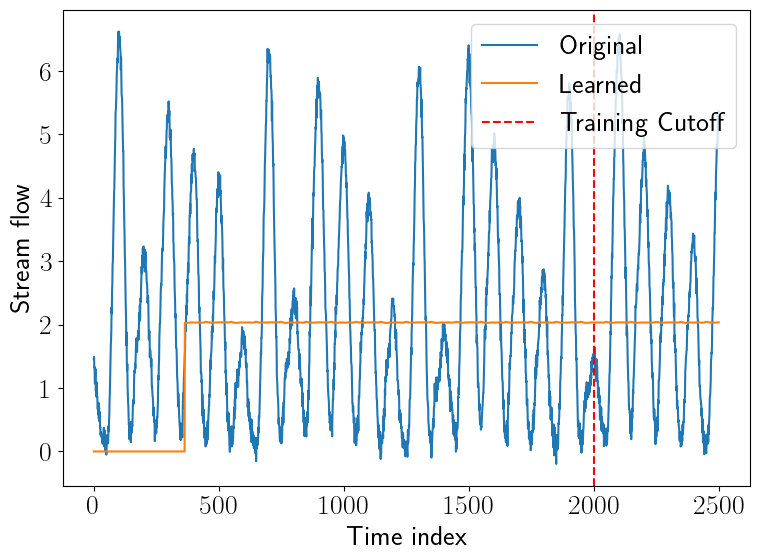

In [11]:
# Plot learned signal
plt.figure(figsize=figsize)
plt.plot(i, v, label='Original')
plt.plot(i, v_net, label='Learned')
plt.axvline(x=i_train[-1], color='r', linestyle='--', label='Training Cutoff')
plt.legend(loc='upper right')
plt.xlabel("Time index")
plt.ylabel("Stream flow")
plt.tight_layout()
plt.show()